In [1]:
import numpy as np
import torch

from floody import data as D
from floody import floody as F

In [11]:
from causalflow import support as Support

In [2]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline 

In [3]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

In [4]:
houst_zipcodes = np.array([77002, 77003, 77004, 77005, 77006, 77007, 77008, 77009, 77010, 77011, 77012, 77013, 77014, 77015, 77016, 77017, 77018, 77019, 77020, 77021, 77022, 77023, 77024, 77025, 77026, 77027, 77028, 77029, 77030, 77031, 77032, 77033, 77034, 77035, 77036, 77037, 77038, 77039, 77040, 77041, 77042, 77043, 77044, 77045, 77046, 77047, 77048, 77049, 77050, 77051, 77053, 77054, 77055, 77056, 77057, 77058, 77059, 77060, 77061, 77062, 77063, 77064, 77065, 77066, 77067, 77068, 77069, 77070, 77071, 77072, 77073, 77074, 77075, 77076, 77077, 77078, 77079, 77080, 77082, 77083, 77084, 77085, 77086, 77087, 77088, 77089, 77090, 77092, 77093, 77094, 77095, 77096, 77098, 77099, 77301, 77302, 77303, 77304, 77306, 77316, 77318, 77327, 77328, 77336, 77338, 77339, 77345, 77346, 77354, 77355, 77356, 77357, 77362, 77365, 77372, 77373, 77375, 77377, 77378, 77379, 77380, 77381, 77382, 77384, 77385, 77386, 77388, 77389, 77396, 77401, 77406, 77407, 77423, 77429, 77430, 77433, 77441, 77447, 77449, 77450, 77459, 77461, 77469, 77471, 77477, 77478, 77479, 77480, 77484, 77486, 77489, 77493, 77494, 77498, 77502, 77503, 77504, 77505, 77506, 77510, 77511, 77515, 77517, 77520, 77521, 77530, 77531, 77532, 77534, 77535, 77536, 77539, 77541, 77545, 77546, 77550, 77551, 77554, 77562, 77563, 77565, 77566, 77568, 77571, 77573, 77575, 77578, 77581, 77583, 77584, 77586, 77587, 77590, 77591, 77598, 77650])

In [5]:
houston = D.read_zipshape(houst_zipcodes)

# compile covariates:
1. mean_monthly_rainfall
2. flood_risk100
3. median_household_income
4. population
5. renter_fraction 
6. educated_fraction
7. white_fraction

In [6]:
Precip = D.Precip()
FloodRisk = D.FloodRisk()
Census = D.Census()
Cmip = D.Forecast()

In [7]:
X_2022 = np.empty((len(np.array(houston['ZIPCODE'])), 7))
for i, zcode in enumerate(np.array(houston['ZIPCODE']).astype(int)): 
    # maximum monthly precipitation in 2022 
    X_2022[i,0] = np.max(Precip._find_zipcode(zcode, 'precip.2022'))
    
    # flood risk100 in 2022
    X_2022[i,1] = FloodRisk._find_zipcode(zcode, 'risk100.2022')[0]
    
    # median income
    X_2022[i,2] = Census._find_zipcode(zcode, 'income')[0]
    
    # population
    X_2022[i,3] = Census._find_zipcode(zcode, 'population')[0]

    # renter fraction
    X_2022[i,4] = Census._find_zipcode(zcode, 'renter_fraction')[0]    
    
    # educated fraction
    X_2022[i,5] = Census._find_zipcode(zcode, 'educated_fraction')[0]

    # white fraction
    X_2022[i,6] = Census._find_zipcode(zcode, 'white_fraction')[0]

In [8]:
X_2030 = X_2022.copy() 
for i, zcode in enumerate(np.array(houston['ZIPCODE']).astype(int)): 
    # precipitation in 2030
    _precip = []
    for month in range(1, 13): 
        _precip.append(Cmip.forecast_latlon(
            np.array(houston['LATITUDE']).astype(float)[i], 
            np.array(houston['LONGITUDE']).astype(float)[i] % 360, 2030, month))

    X_2030[i,0] = np.max(np.array(_precip)) #np.max(np.median(np.array(_precip), axis=1))

    # flood risk100 in 2022
    _risk2052 = FloodRisk._find_zipcode(zcode, 'risk100.2052')[0]
    _risk2022 = FloodRisk._find_zipcode(zcode, 'risk100.2022')[0]
    X_2030[i,1] = (_risk2052 - _risk2022)/30. * (2030 - 2022)

In [9]:
X_2040 = X_2022.copy() 
for i, zcode in enumerate(np.array(houston['ZIPCODE']).astype(int)): 
    # precipitation in 2040
    _precip = []
    for month in range(1, 13): 
        _precip.append(Cmip.forecast_latlon(
            np.array(houston['LATITUDE']).astype(float)[i], 
            np.array(houston['LONGITUDE']).astype(float)[i] % 360, 2040, month))

    X_2040[i,0] = np.max(np.array(_precip)) #np.max(np.median(np.array(_precip), axis=1))

    # flood risk100 in 2022
    _risk2052 = FloodRisk._find_zipcode(zcode, 'risk100.2052')[0]
    _risk2022 = FloodRisk._find_zipcode(zcode, 'risk100.2022')[0]
    X_2040[i,1] = (_risk2052 - _risk2022)/30. * (2040 - 2022)

In [10]:
X_2052 = X_2022.copy() 
for i, zcode in enumerate(np.array(houston['ZIPCODE']).astype(int)): 
    # precipitation in 2052
    _precip = []
    for month in range(1, 13): 
        _precip.append(Cmip.forecast_latlon(
            np.array(houston['LATITUDE']).astype(float)[i], 
            np.array(houston['LONGITUDE']).astype(float)[i] % 360, 2052, month))

    X_2052[i,0] = np.max(np.array(_precip)) #np.max(np.median(np.array(_precip), axis=1))

    # flood risk100 in 2052
    X_2052[i,1] = FloodRisk._find_zipcode(zcode, 'risk100.2052')[0]

In [12]:
# read and load control support (currently hardcoded)
Supp = Support.Support()
Supp.load_optuna('support.control', '/scratch/gpfs/chhahn/noah/floody/support/',
        verbose=False)

In [23]:
_X_2022 = X_2022.copy()
_X_2022[:,2] = np.log10(_X_2022[:,2])
_X_2022[:,3] = np.log10(_X_2022[:,3])
in_support2022 = Supp.check_support(_X_2022, Nsample=10000, threshold=0.95)

In [19]:
fema = D.FEMA()
XY, _ = fema.prepare_train_test('control', split=1., seed=42)

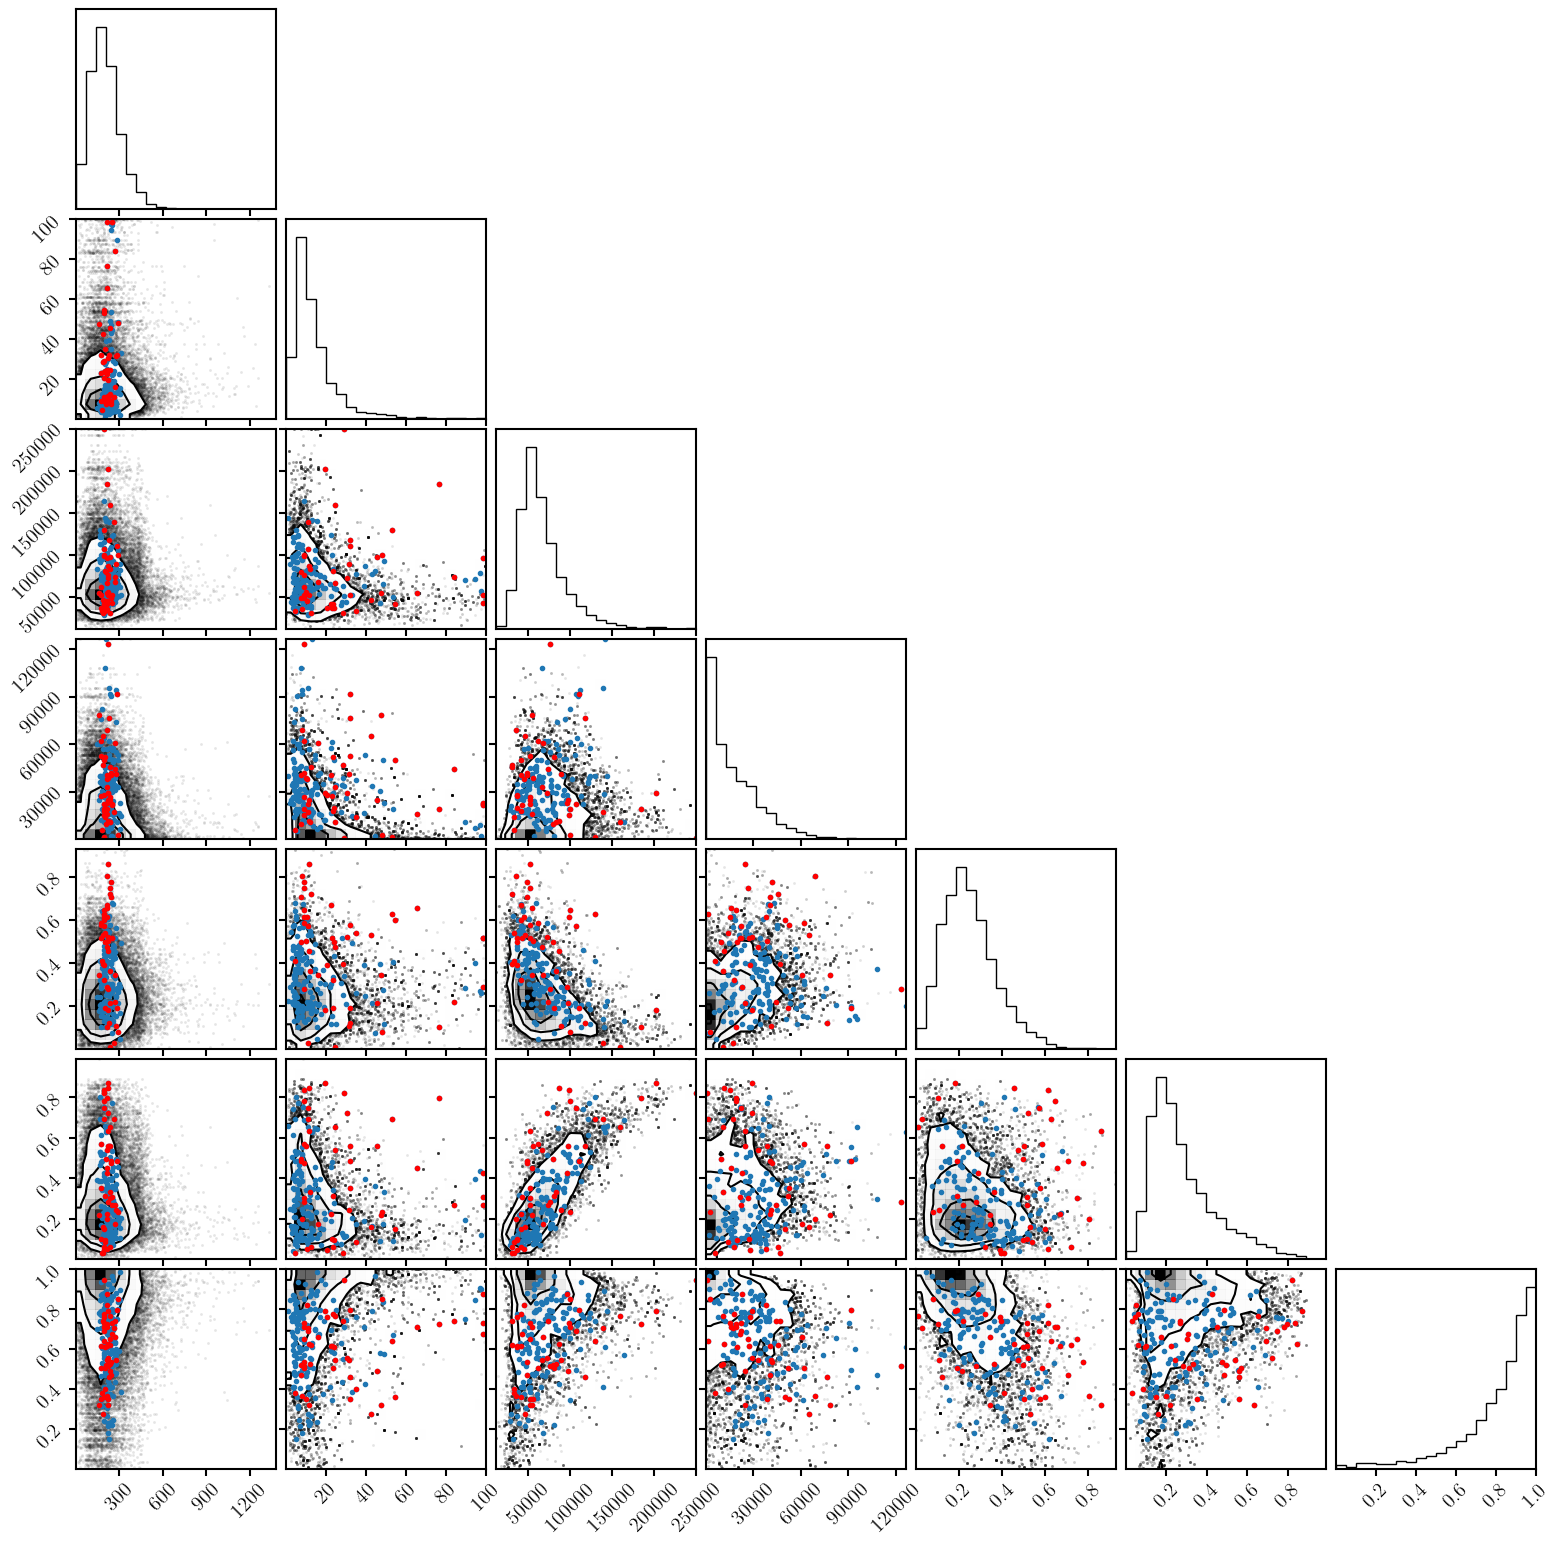

In [24]:
fig = DFM.corner(XY[:,1:])
DFM.overplot_points(fig, X_2022, color='C0')
DFM.overplot_points(fig, X_2022[~in_support2022], color='r')

In [30]:
_X_flow = Supp.flow_support.sample(10000)
X_flow = _X_flow.detach().numpy().copy()
X_flow[:,2] = 10**X_flow[:,2]
X_flow[:,3] = 10**X_flow[:,3]

/tmp/ipykernel_2176725/1206735611.py:4: RuntimeWarning: overflow encountered in power
  X_flow[:,3] = 10**X_flow[:,3]


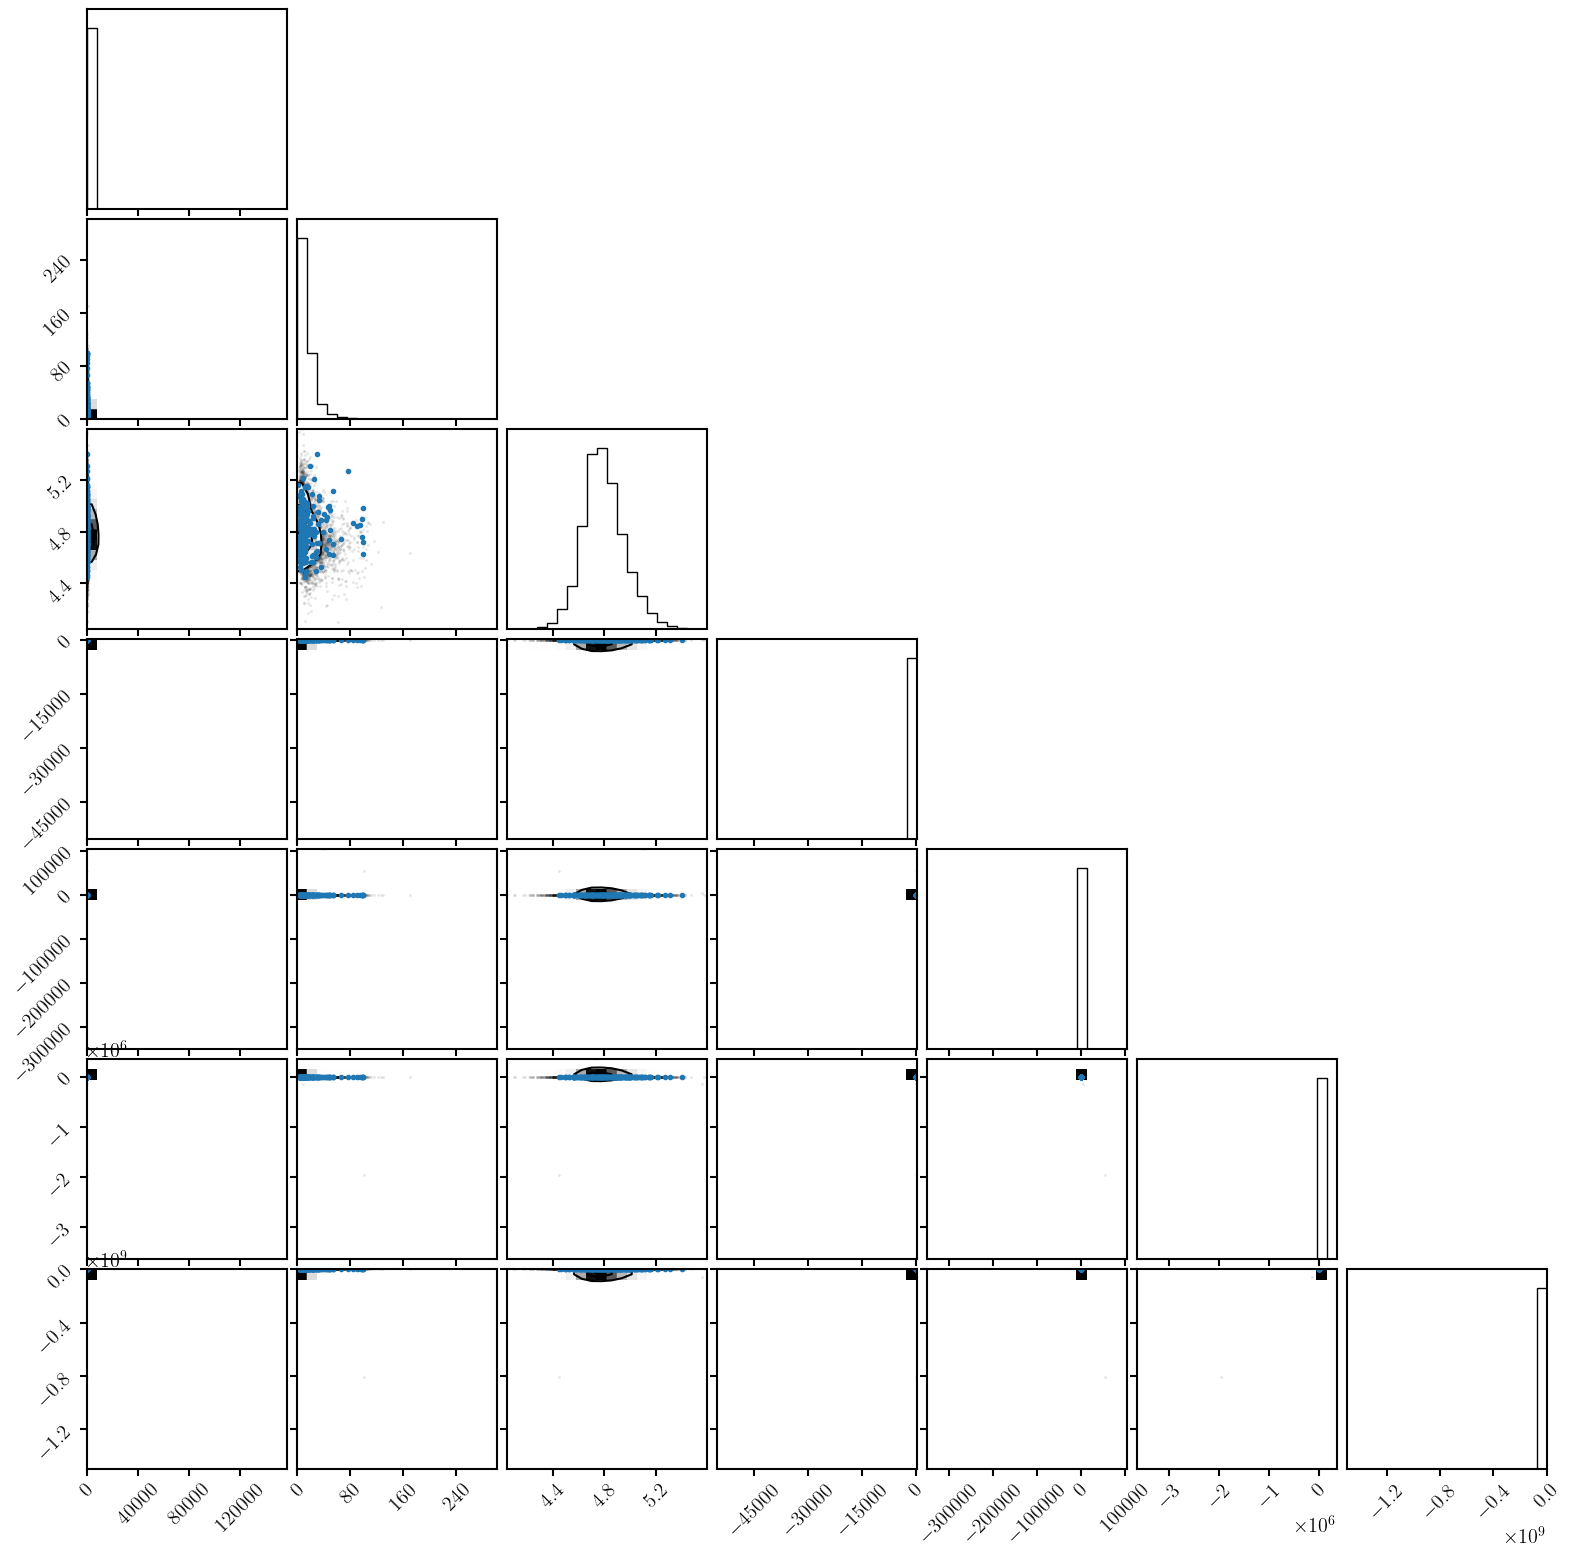

In [35]:

fig = DFM.corner(_X_flow.detach().numpy())
DFM.overplot_points(fig, _X_2022, color='C0')